__微调fine-tuning__：
    收集更多的数据--替代方案-->迁移学习：从源数据集学习到的知识迁移到目标数据集
例如，尽管ImageNet数据集中大多数图像与椅子无关，但在此数据集上训练的模型可以提取更通用的图像特征，有助于识别边缘、纹理、形状和对象组合。这些类似的特征也可能有效地识别椅子。
    源模型：在源数据集上预训练的模型
    源模型的输出层就不要了，因为它和源数据集的标签密切相关。向目标模型添加输出层，输出数是目标数据集类别数，随机初始化该层的参数
    在目标数据集上训练目标模型，输出层将从头开始训练，其它层根据源模型参数进行微调
    _当目标数据集比源数据集小得多时，微调有助于提高模型泛化能力_

In [1]:
%matplotlib inline
import os, torch, torchvision
from torch import nn
from d2l import torch as d2l

In [2]:
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip', 'fba480ffa8aa7e0febbb511d181409f899b9baa5')
data_dir = d2l.download_extract('hotdog')

In [3]:
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

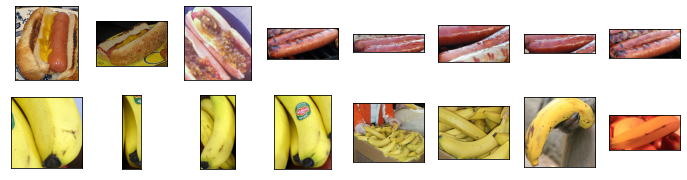

In [4]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [test_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.5)

图像标准化--每个像素值减去均值，然后结果除以标准差

In [5]:
""" 标准化 """
normalize = torchvision.transforms.Normalize(
    [.485, .456, .406], [.229, .224, .225]
)
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(56),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize
])
test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(56),
    torchvision.transforms.ToTensor(),
    normalize
])

In [6]:
pretrained_net = torchvision.models.resnet18(pretrained=True)

In [7]:
pretrained_net.fc   # 源模型成员变量fc

Linear(in_features=512, out_features=1000, bias=True)

In [8]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)     # 把目标模型的输出层输出数量设置为目标数据集类别数
nn.init.xavier_uniform_(finetune_net.fc.weight)     # 随机初始化输出层权重

Parameter containing:
tensor([[ 0.0472, -0.0904,  0.0159,  ...,  0.0359, -0.0397,  0.0202],
        [-0.0162,  0.1001, -0.1034,  ...,  0.0427, -0.0659, -0.0659]],
       requires_grad=True)

In [9]:
from random import shuffle


def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5, param_group=True):
    train_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_augs), 
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_augs),
        batch_size=batch_size
    )
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction='none')
    if param_group:
        params_lx = [param for name, param in net.named_parameters() if name not in ['fc.weight', 'fc.bias']]
        trainer = torch.optim.SGD([{'params':params_lx},
                                {'params':net.fc.parameters(), 'lr':learning_rate * 10}],
                                lr=learning_rate, weight_decay=.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

loss 0.171, train acc 0.926, test acc 0.881
237.1 examples/sec on [device(type='cuda', index=0)]


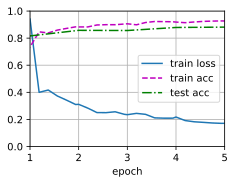

In [10]:
train_fine_tuning(finetune_net, 5e-5)

loss 0.365, train acc 0.835, test acc 0.738
259.0 examples/sec on [device(type='cuda', index=0)]


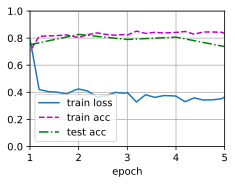

In [12]:
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)